# Time Series Analysis
by Chee-Foong
on 18 Mar 2020

This analysis explores historical electricity system demand for every half hour period (MW) in Singapore.  The data is shared by Energy Market Authority and can be found here: https://data.gov.sg/dataset/half-hourly-system-demand

## Initialising the libraries

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import sys  
sys.path.append('../src') 
from edge import *

In [3]:
import requests
import json
import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(14,10), 'figure.dpi':120})

## Data Extraction
There is 2 ways to download the data from data.gov.sg
1. Make use of the data.gov.sg API
2. Go to the website directly and download the csv

### 1. Extracting Data from data.gov.sg API
*Notes:*
- *data.gov.sg limits the number of records request per api request*
- *need to send multiple requests with record offsets to download the full dataset*


In [4]:
# data['result']['fields']

In [5]:
DATAGOV_URL = 'https://data.gov.sg/api/action/datastore_search?resource_id=85e22503-74c8-43a1-8cee-f4e4b1d9c5fc'
STEP = 10000
NUM_OF_RECORDS = 100000
datalist = []

for recordid in range(0,NUM_OF_RECORDS,STEP):
    print('Processing {}...'.format(recordid))
    url = DATAGOV_URL + '&limit='+ str(STEP) +'&offset=' + str(recordid)
    data = requests.get(url)
    data = data.json()

    try:
        data = pd.DataFrame(data['result']['records'])
        data['datetime'] = data['date'] + ' ' + data['period_ending_time']
        data['datetime'] = pd.to_datetime(data['datetime'], format="%Y-%m-%d %H:%M")
        data.set_index('datetime', inplace=True)
        data.drop(['_id','date','period_ending_time'], axis = 1, inplace=True)
        data = data.replace('na', np.nan)

        datalist.append(data)
    except:
        break

full_data = pd.concat(datalist, axis=0, ignore_index=False).dropna(axis=0)
full_data = full_data.apply(pd.to_numeric) 
full_data.sort_index(inplace=True)

print('Done')


Processing 0...
Processing 10000...
Processing 20000...
Processing 30000...
Processing 40000...
Processing 50000...
Processing 60000...
Processing 70000...
Processing 80000...
Done


In [6]:
full_data

,system_demand_actual,nem_demand_actual,nem_demand_forecast
datetime,,,
2014-09-29 00:30:00,5311,5229,5143
2014-09-29 01:00:00,5176,5090,5032
2014-09-29 01:30:00,5100,5015,4953
2014-09-29 02:00:00,5024,4938,4880
2014-09-29 02:30:00,4957,4871,4834
...,...,...,...
2016-06-05 22:00:00,5862,5784,5783
2016-06-05 22:30:00,5756,5684,5679
2016-06-05 23:00:00,5674,5592,5606


### 2. Extract data from csv downloaded from data.gov.sg
*Notes*
- *csv file downloaded from the website (half-hourly-system-demand-data-from-2-feb-2012-onwards.csv)*
- *csv file saved in the root/data directory*


In [7]:
def formatTimeSeries(df):
    df['datetime'] = df['date'] + ' ' + df['period_ending_time']
    df['datetime'] = pd.to_datetime(df['datetime'], format="%Y-%m-%d %H:%M")
    df.set_index('datetime', inplace=True)
    df.drop(['date','period_ending_time'], axis = 1, inplace=True)
    df = df.replace('na', np.nan)
    return df

In [8]:
full_data2 = pd.read_csv('../data/half-hourly-system-demand-data-from-2-feb-2012-onwards.csv')
full_data2 = formatTimeSeries(full_data2.copy()).dropna(axis = 0)
full_data2 = full_data2.apply(pd.to_numeric) 
full_data2.sort_index(inplace=True)
full_data2.shape

(29568, 3)

### Data sanity check
Given that it is a time series data, check the datetime index to ensure data is complete with the right frequency.  If not, time series will need forward filled or interpolated to ensure completeness.

In [28]:
from datetime import datetime, timedelta

# Set start and end dates
start = full_data.index[0]
end = full_data.index[-1]

# Create monthly_dates here
new_datetime = pd.date_range(start, end, freq='30min')

print('Shape of expected datetimeindex: {}'.format(new_datetime.shape))
print('Shape of full_data: {}'.format(full_data.index.shape))
print('Shape of full_data2: {}'.format(full_data2.index.shape))

print(new_datetime.difference(full_data.index))
print(new_datetime.difference(full_data2.index))

#full_data.iloc[~full_data.index.isin(new_datetime)]

Shape of expected datetimeindex: (29568,)
Shape of full_data: (29568,)
Shape of full_data2: (29568,)
DatetimeIndex([], dtype='datetime64[ns]', freq='30T')
DatetimeIndex([], dtype='datetime64[ns]', freq='30T')


No difference in datetimeindex observed

In [45]:
full_data.to_csv('../data/full_data_cleaned.csv')

## Data Exploratory for Time Series Analysis

In [29]:
demand_data = full_data.copy()

In [30]:
print('Date range of data from {} to {}'.format(demand_data.index.min(), demand_data.index.max()))

Date range of data from 2014-09-29 00:30:00 to 2016-06-06 00:00:00


### Snapshot of energy demand in May 2015
Half hourly demand over the month

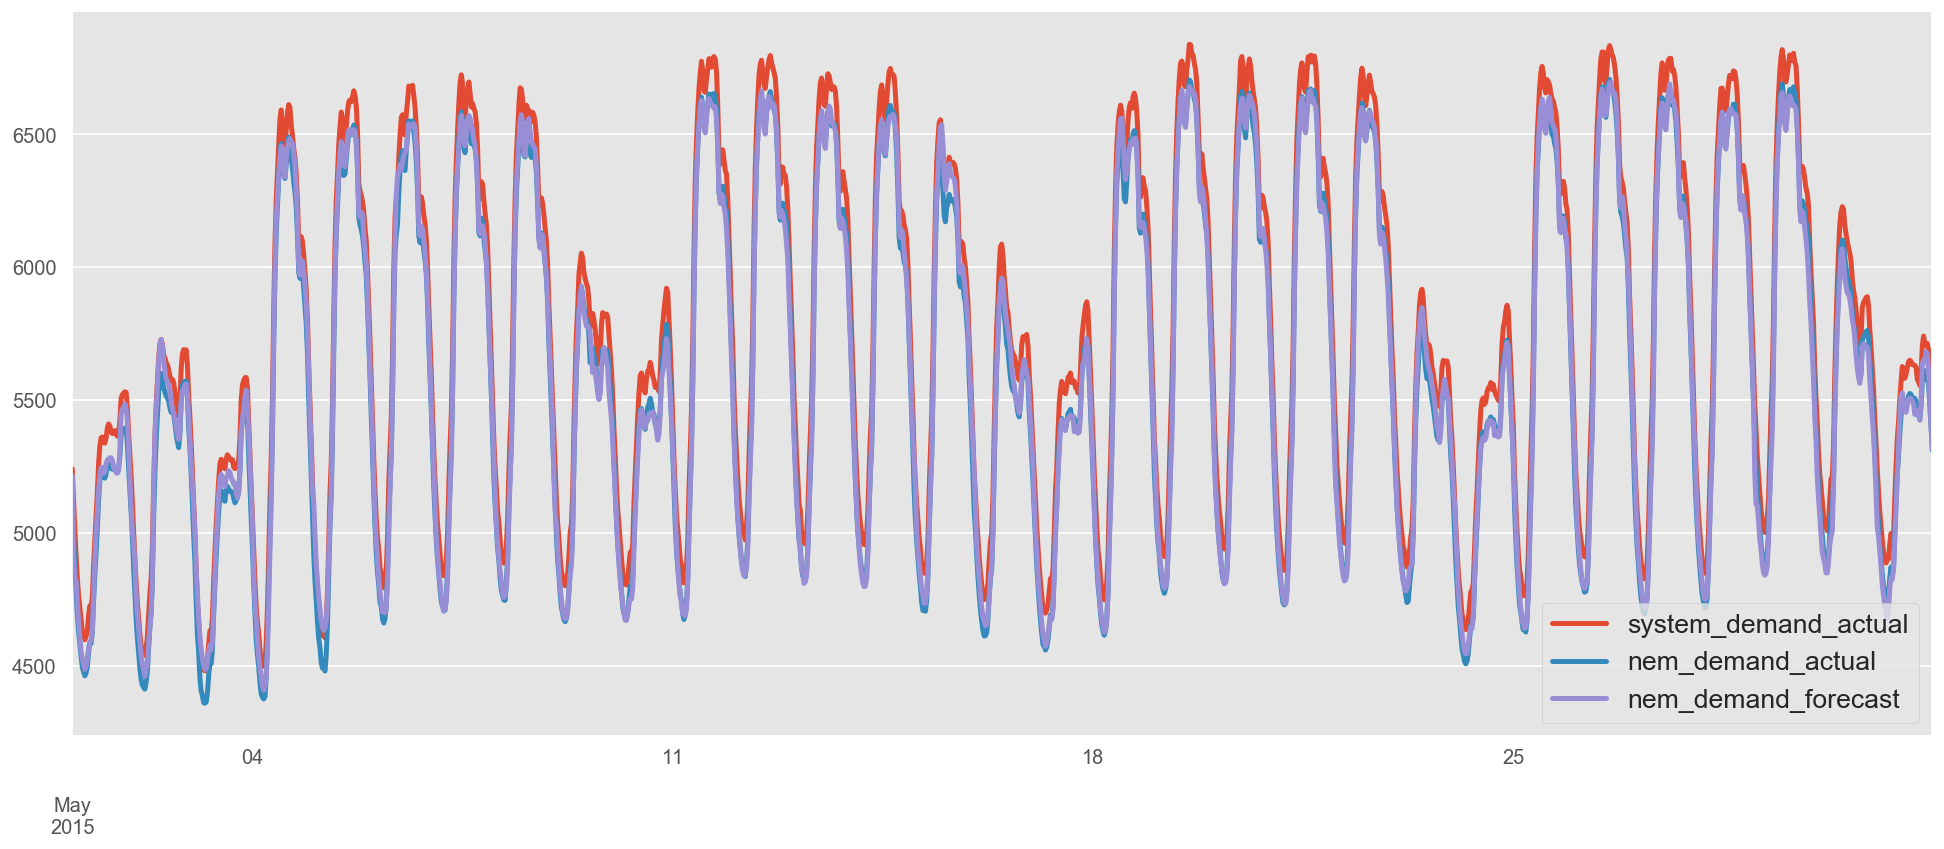

In [35]:
plotTimeSeries(demand_data['2015-05'])

Daily average demand over the month

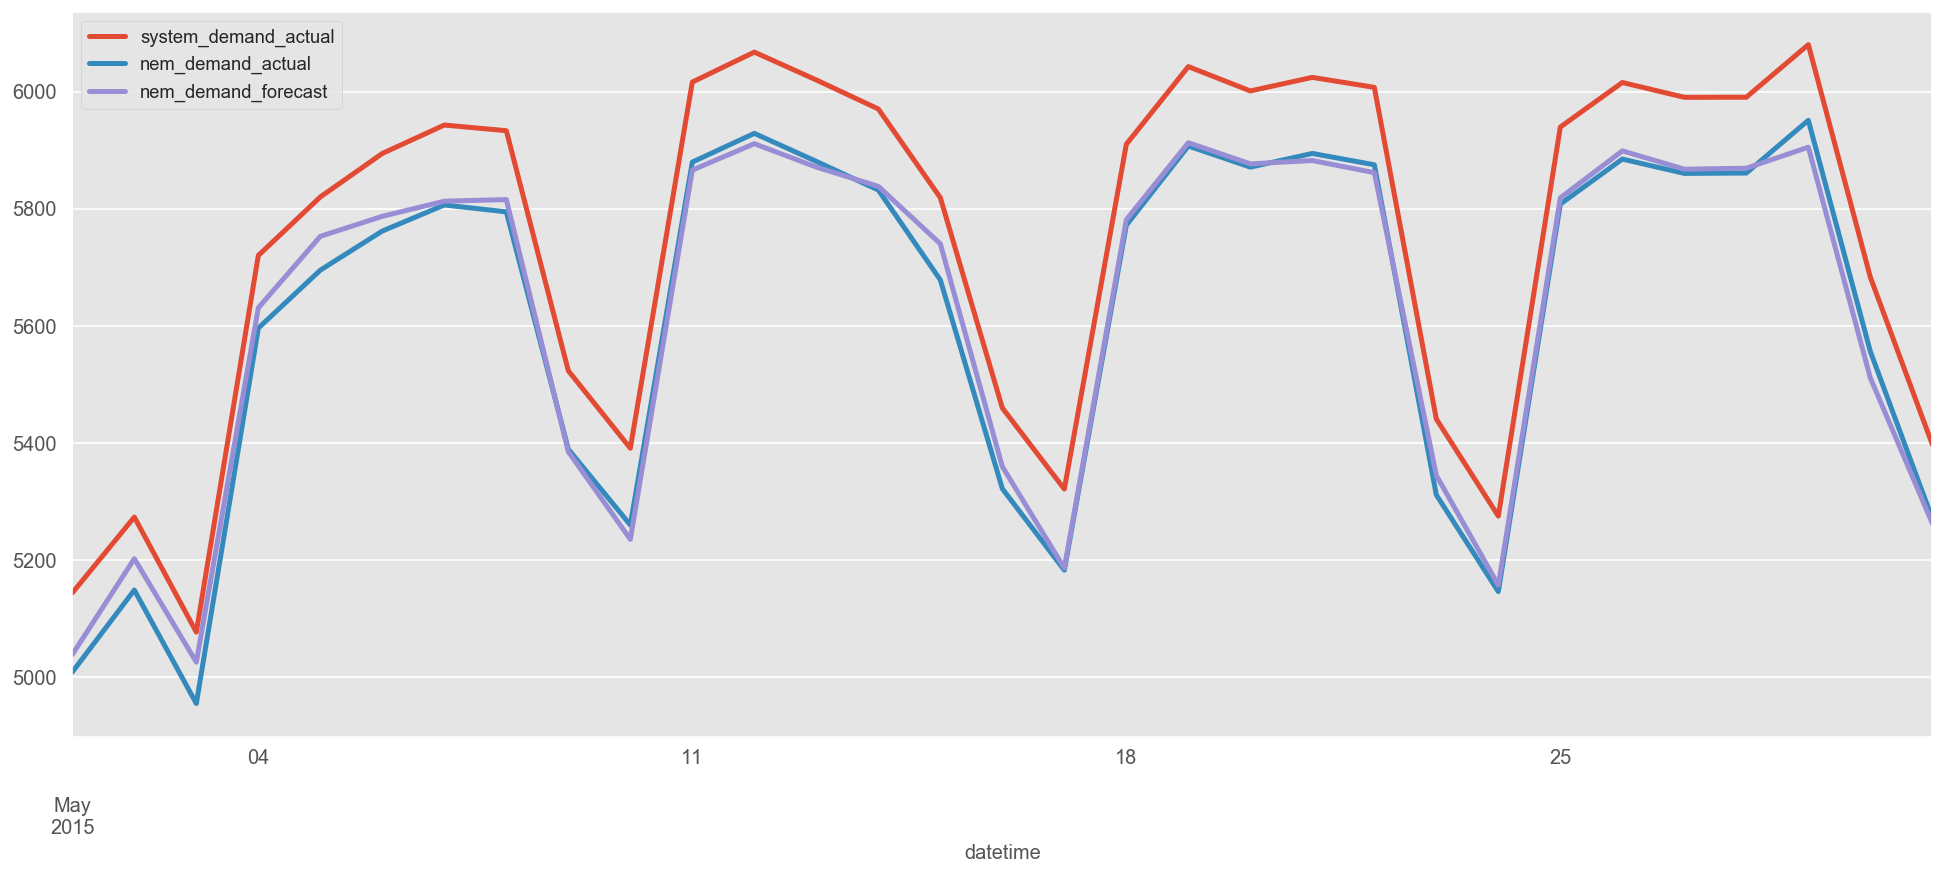

In [39]:
demand_data.resample('D').mean()['2015-05'].plot(figsize=FIG_SIZE, fontsize=12, linewidth=3, linestyle='-')
plt.show()

### Average energy demand by day of week

In [40]:
day_mapper = {}

for i, val in enumerate(list(calendar.day_abbr)): 
    day_mapper[i] = val

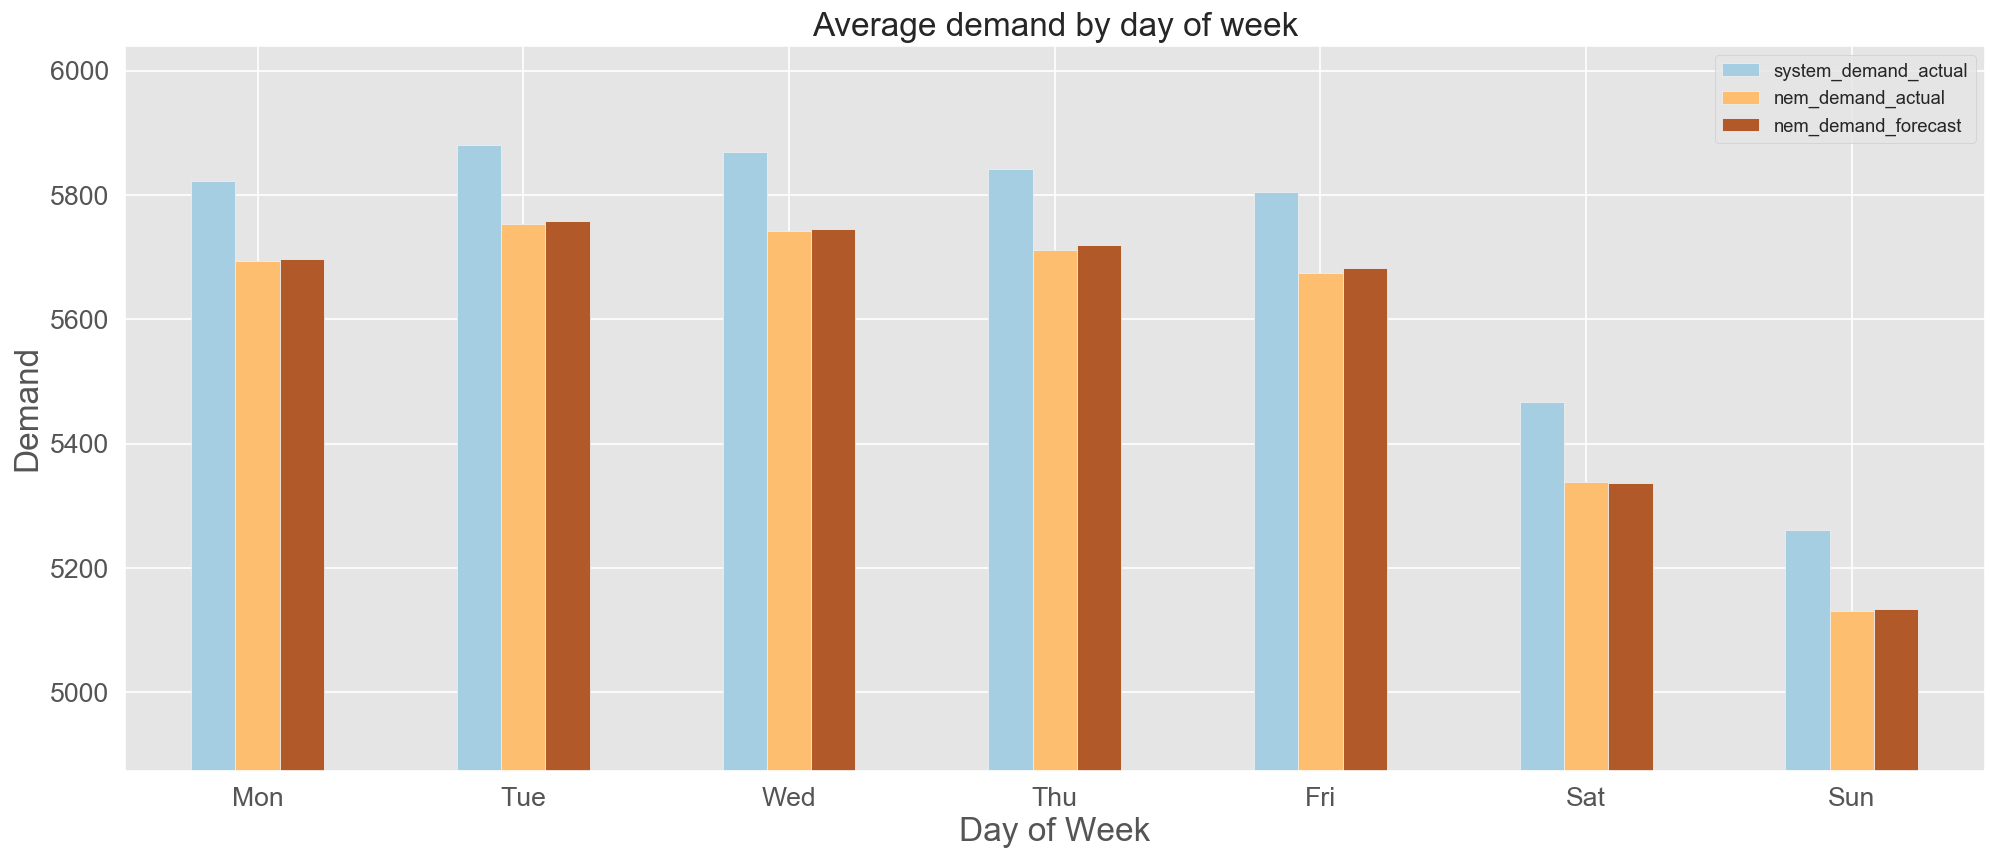

In [41]:
# Extract the month from the index of jobs
index_dayofweek = demand_data.index.dayofweek

fig, ax = plt.subplots(figsize=FIG_SIZE)

# Compute the mean unemployment rate for each month
demand_data_by_dayofweek = demand_data.groupby(index_dayofweek).mean()
demand_data_by_dayofweek.index = demand_data_by_dayofweek.index.map(day_mapper)

y_min = int(min(demand_data_by_dayofweek.min()*0.95))
y_max = int(min(demand_data_by_dayofweek.max()*1.05))

# Plot the mean unemployment rate for each month
demand_data_by_dayofweek.plot(kind='bar', fontsize=16, rot=0, ylim=(y_min, y_max), colormap='Paired', ax=ax)

# Set axis labels and legend
ax.set_title('Average demand by day of week', fontsize=20)
ax.set_xlabel('Day of Week', fontsize=20)
ax.set_ylabel('Demand', fontsize=20)
# ax.legend(fontsize=20)
plt.show()

### Average energy demand by month

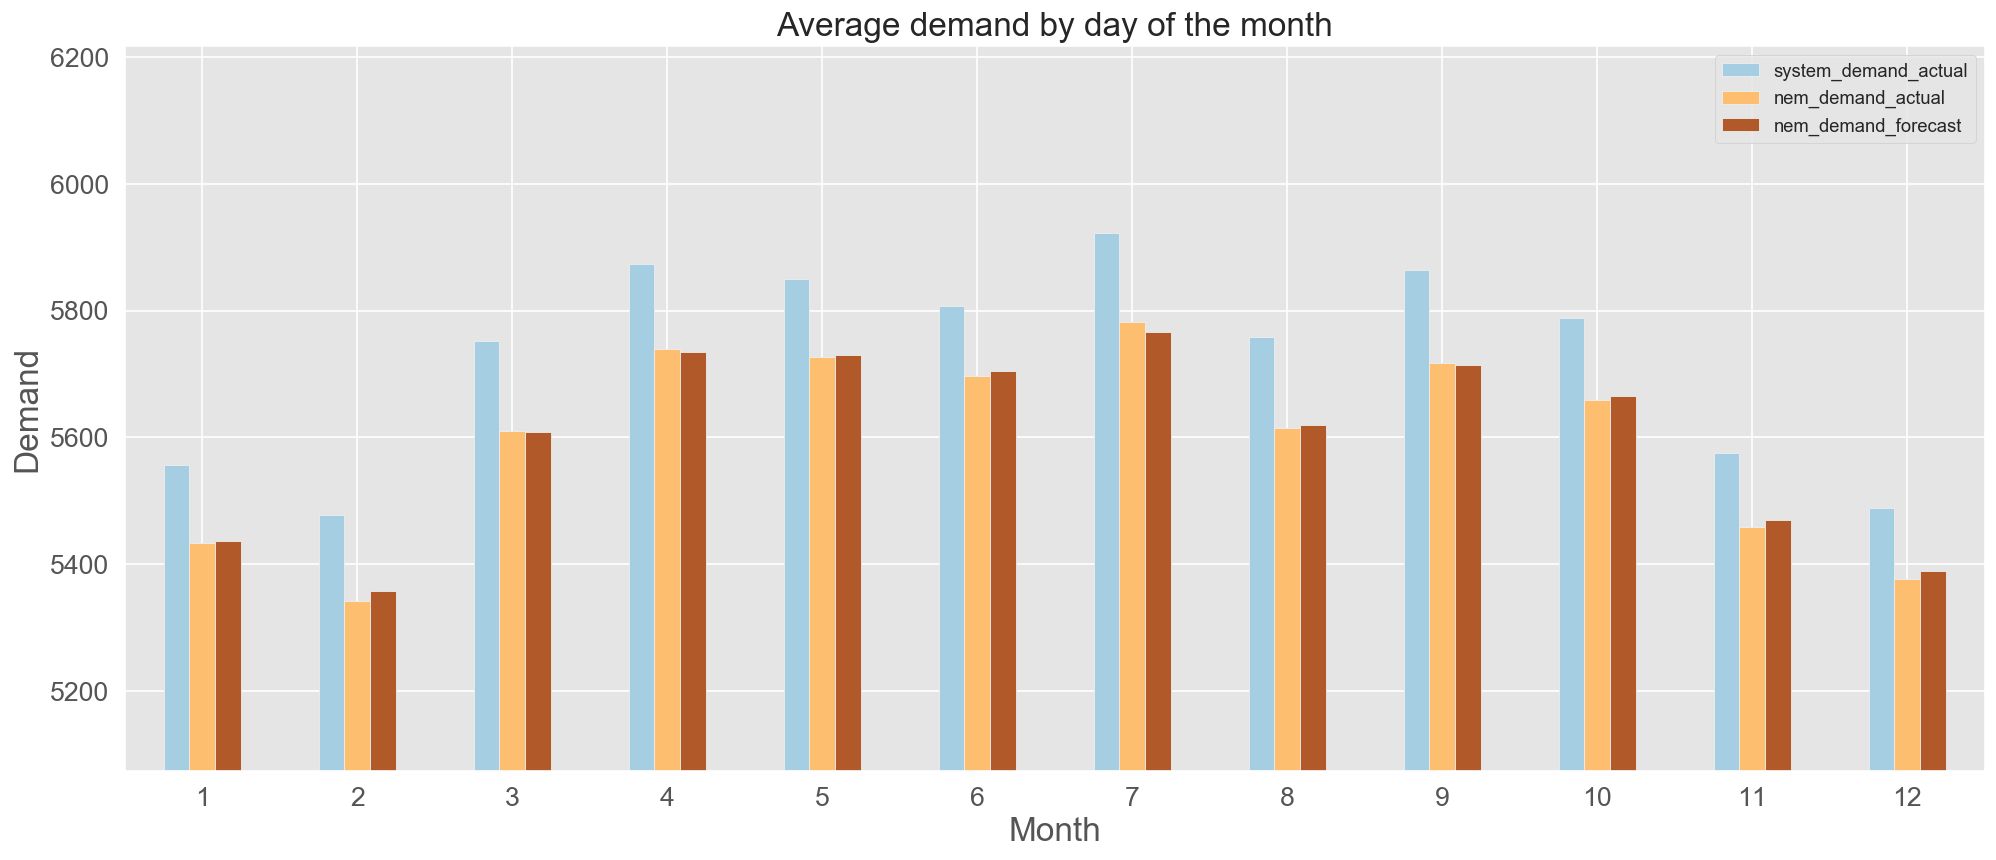

In [42]:
# Extract the month from the index of jobs
index_month = demand_data.index.month

fig, ax = plt.subplots(figsize=FIG_SIZE)

# Compute the mean unemployment rate for each month
demand_data_by_month = demand_data.groupby(index_month).mean()
y_min = int(min(demand_data_by_month.min()*0.95))
y_max = int(max(demand_data_by_month.max()*1.05))

# Plot the mean unemployment rate for each month
demand_data_by_month.plot(kind='bar', ax=ax, fontsize=16, rot=0, ylim=(y_min, y_max), colormap='Paired')

# Set axis labels and legend
ax.set_title('Average demand by day of the month', fontsize=20)
ax.set_xlabel('Month', fontsize=20)
ax.set_ylabel('Demand', fontsize=20)
# ax.legend(fontsize=20)
plt.show()

### Average energy demand by hour of each day

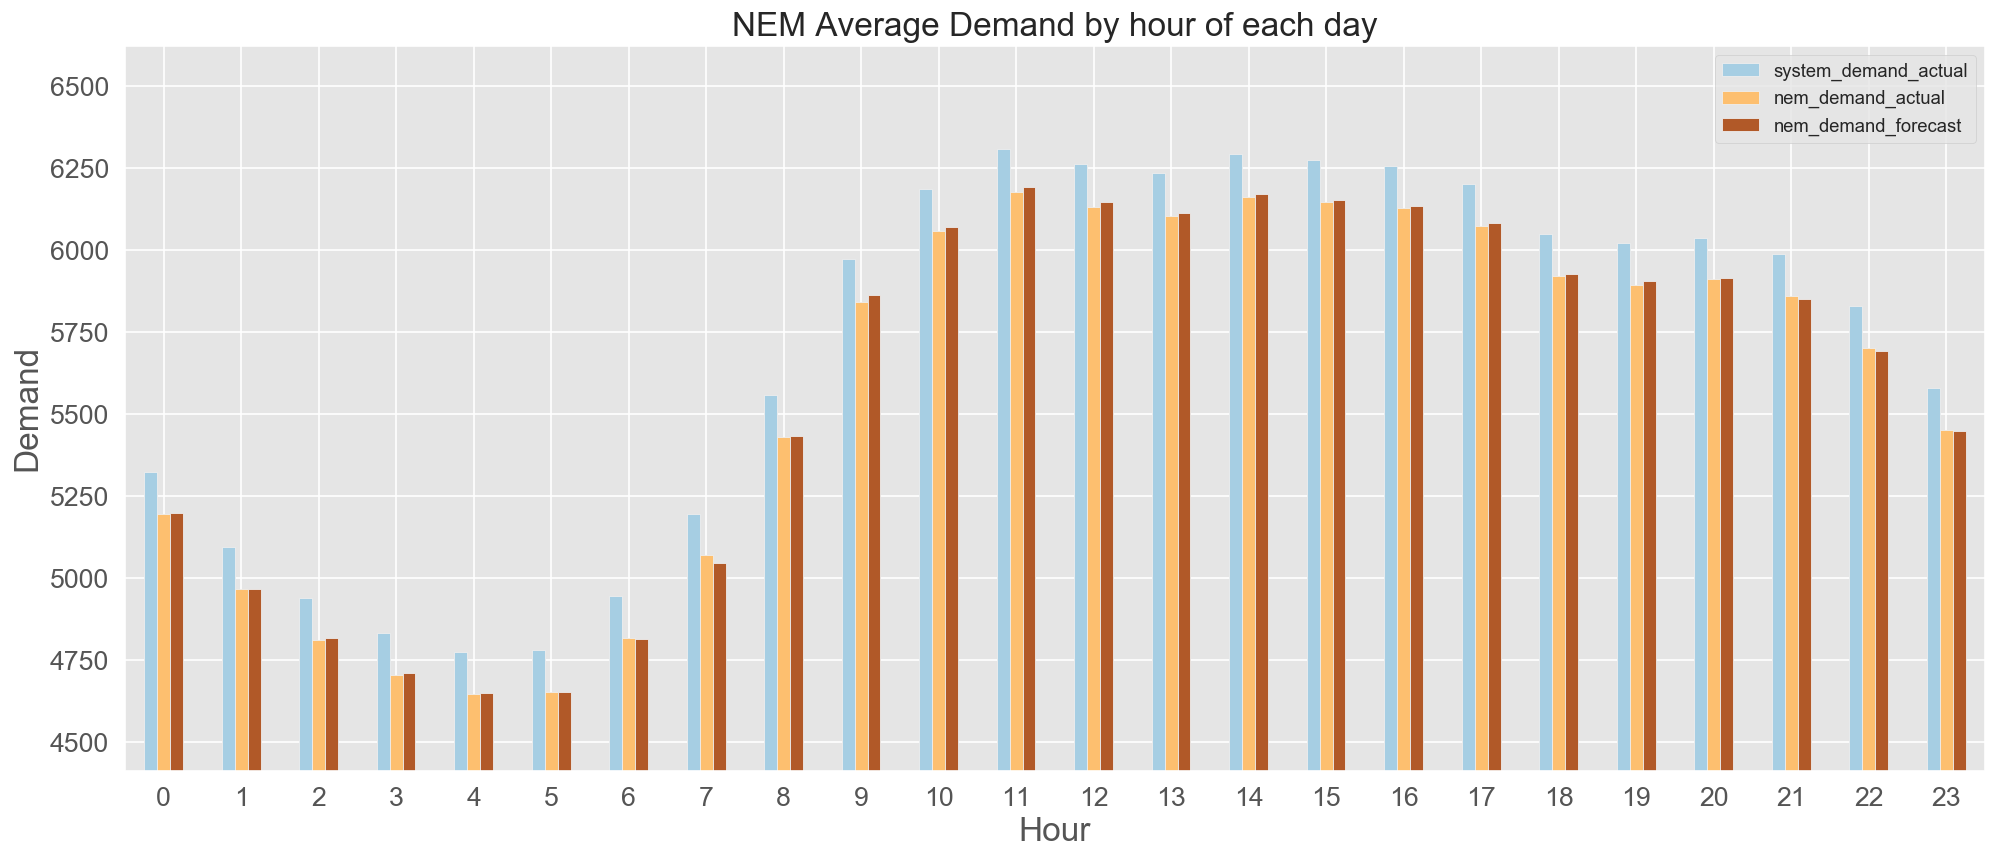

In [43]:
# Extract the month from the index of jobs
index_hour = demand_data.index.hour

fig, ax = plt.subplots(figsize=FIG_SIZE)

# Compute the mean unemployment rate for each month
demand_data_by_hour = demand_data.groupby(index_hour).mean()
y_min = int(min(demand_data_by_hour.min()*0.95))
y_max = int(max(demand_data_by_hour.max()*1.05))

# Plot the mean unemployment rate for each month
demand_data_by_hour.plot(kind='bar', ax=ax, fontsize=16, rot=0, ylim=(y_min, y_max), colormap='Paired')

# Set axis labels and legend
ax.set_title('NEM Average Demand by hour of each day', fontsize=20)
ax.set_xlabel('Hour', fontsize=20)
ax.set_ylabel('Demand', fontsize=20)
# ax.legend(fontsize=20)
plt.show()

### Data Observations
1. Observe lower energy demand over weekends (Sat and Sun).  Expect similar demands for holidays if such information is available.
2. Observe higher energy demand between Mar to Oct.  Possibly due to hotter weather during this period in Singapore and holiday periods at the beginning and end of each year.
3. Observe higher energy demand between 8am to 11pm when businesses are at work.

## Next Steps
Time Series Analysis and Forecasting....